In [1]:
# ДЗ 2
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

### 1. Импорт и загрузка

In [2]:
import cv2
import matplotlib
import numpy as np
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

img_color = cv2.imread("img.jpg")
img_gray = cv2.imread("sar_1.jpg", cv2.IMREAD_GRAYSCALE)

### 2. Исходное изображение и результаты добавления гауссовского и равномерного шума

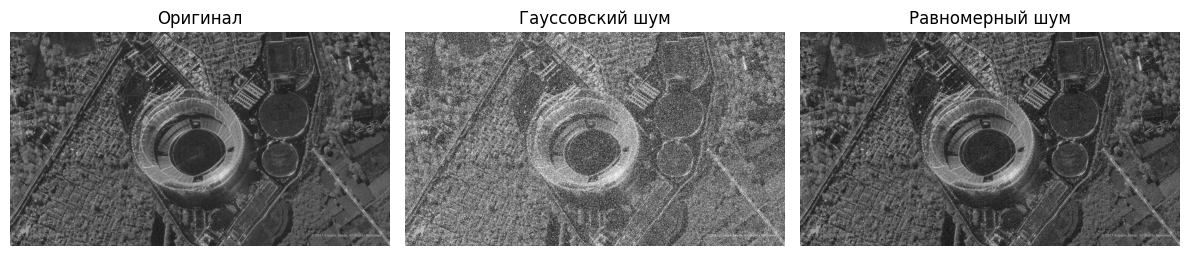

In [3]:
# Гауссовский шум
mean = 0
stddev = 100
noise_gauss = np.zeros(img_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)
image_noise_gauss = cv2.add(img_gray, noise_gauss)

# Равномерный шум
noise_level = 30
uniform_noise = np.random.uniform(-noise_level, noise_level, img_gray.shape)
image_noise_uniform = np.clip(img_gray.astype(np.float32) + uniform_noise, 0, 255).astype(np.uint8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Оригинал")
plt.imshow(img_gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Гауссовский шум")
plt.imshow(image_noise_gauss, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Равномерный шум")
plt.imshow(image_noise_uniform, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

### 3. Результаты фильтрации изображения, искажённого гауссовским шумом

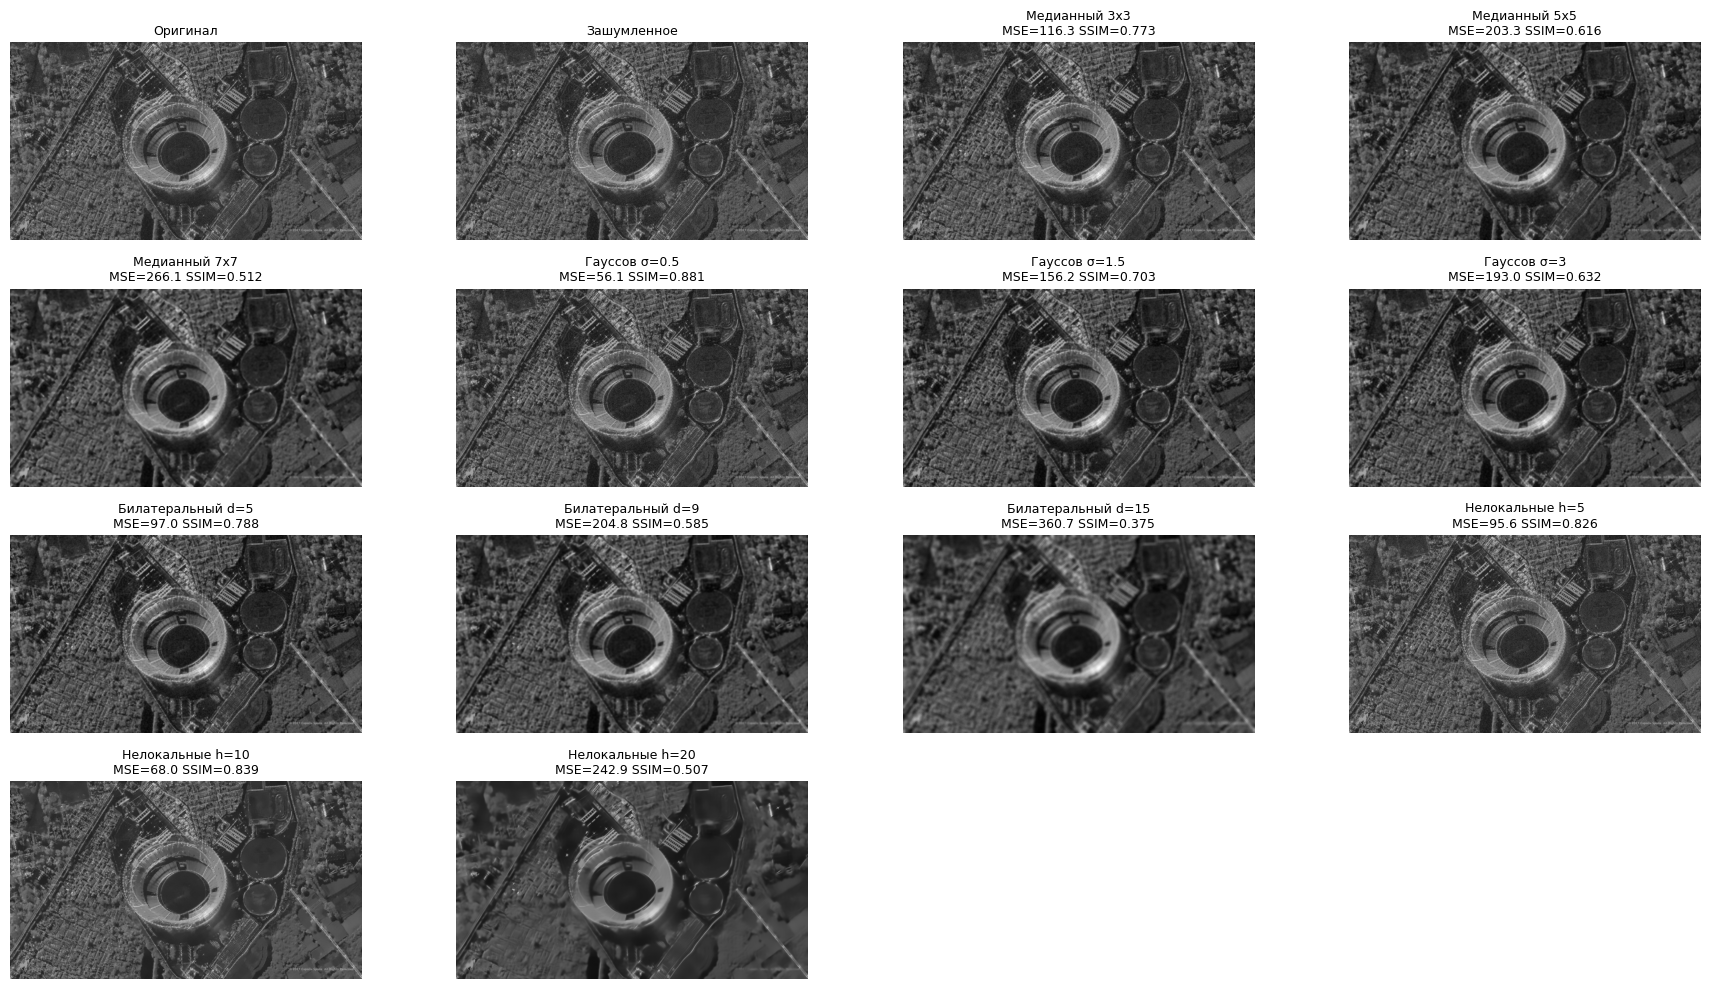

In [4]:
from skimage.metrics import mean_squared_error
# Гауссовский шум
mean = 0
var = 100
sigma = var ** 0.5
gauss = np.random.normal(mean, sigma, img_gray.shape).astype(np.float32)
noisy = np.clip(img_gray.astype(np.float32) + gauss, 0, 255).astype(np.uint8)

results = [("Оригинал", img_gray),
           ("Зашумленное", noisy)]

# Медианный фильтр
for ksize in [3, 5, 7]:
    filtered = cv2.medianBlur(noisy, ksize)
    mse_val = mean_squared_error(img_gray, filtered)
    ssim_val = ssim(img_gray, filtered)
    results.append((f"Медианный {ksize}x{ksize}\nMSE={mse_val:.1f} SSIM={ssim_val:.3f}", filtered))

# Гауссов фильтр
for sigma in [0.5, 1.5, 3]:
    filtered = cv2.GaussianBlur(noisy, (5, 5), sigma)
    mse_val = mean_squared_error(img_gray, filtered)
    ssim_val = ssim(img_gray, filtered)
    results.append((f"Гауссов σ={sigma}\nMSE={mse_val:.1f} SSIM={ssim_val:.3f}", filtered))

# Билатериальный фильтр
params_bilateral = [(5, 50, 50), (9, 75, 75), (15, 150, 150)]
for (d, sC, sS) in params_bilateral:
    filtered = cv2.bilateralFilter(noisy, d, sC, sS)
    mse_val = mean_squared_error(img_gray, filtered)
    ssim_val = ssim(img_gray, filtered)
    results.append((f"Билатеральный d={d}\nMSE={mse_val:.1f} SSIM={ssim_val:.3f}", filtered))

# Нелокальные средние
params_nlm = [(5, 3, 15), (10, 7, 21), (20, 10, 31)]
for (h, t, w) in params_nlm:
    filtered = cv2.fastNlMeansDenoising(noisy, None, h, t, w)
    mse_val = mean_squared_error(img_gray, filtered)
    ssim_val = ssim(img_gray, filtered)
    results.append((f"Нелокальные h={h}\nMSE={mse_val:.1f} SSIM={ssim_val:.3f}", filtered))

plt.figure(figsize=(18, 10))
for i, (name, image) in enumerate(results, start=1):
    plt.subplot(4, 4, i)
    plt.imshow(image, cmap="gray")
    plt.title(name, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

### 4. Сравнение фильтров по качеству восстановления изображения

In [5]:
def test_filters(noisy_img, original):
    results = {}

    filtered = cv2.medianBlur(noisy_img, 3)
    results["Медианный"] = (mean_squared_error(original, filtered), ssim(original, filtered))

    filtered = cv2.GaussianBlur(noisy_img, (5, 5), 0.5)
    results["Гауссовский"] = (mean_squared_error(original, filtered), ssim(original, filtered))

    filtered = cv2.bilateralFilter(noisy_img, 9, 75, 75)
    results["Билатериальный"] = (mean_squared_error(original, filtered), ssim(original, filtered))

    filtered = cv2.fastNlMeansDenoising(noisy_img, None, 10, 7, 21)
    results["NLM"] = (mean_squared_error(original, filtered), ssim(original, filtered))

    return results

results_gauss = test_filters(image_noise_gauss, img_gray)
results_uniform = test_filters(image_noise_uniform, img_gray)

print("\nГауссов шум")
for name, (mse_val, ssim_val) in results_gauss.items():
    print(f"{name} MSE={mse_val}  SSIM={ssim_val}")

print("\nПостоянный шум")
for name, (mse_val, ssim_val) in results_uniform.items():
    print(f"{name} MSE={mse_val}  SSIM={ssim_val}")

best_gauss = min(results_gauss.items(), key=lambda x: x[1][0])
best_uniform = min(results_uniform.items(), key=lambda x: x[1][0])

print("\nИтог ")
print(f"Оптимальный фильтр при гауссовом шуме по MSE: {best_gauss[0]} MSE={best_gauss[1][0]}, SSIM={best_gauss[1][1]}")
print(f"Оптимальный фильтр при постоянном шуме по MSE: {best_uniform[0]}  MSE={best_uniform[1][0]}, SSIM={best_uniform[1][1]:}")



Гауссов шум
Медианный MSE=1038.0502259259258  SSIM=0.4282426278384901
Гауссовский MSE=2618.0085716049384  SSIM=0.2967872902472933
Билатериальный MSE=1837.5518037037036  SSIM=0.3144656208676585
NLM MSE=4230.6725160493825  SSIM=0.18699404041630344

Постоянный шум
Медианный MSE=171.41943086419752  SSIM=0.6799695072618551
Гауссовский MSE=139.09526666666667  SSIM=0.7518375573317042
Билатериальный MSE=200.1508962962963  SSIM=0.6035009128592342
NLM MSE=270.7833049382716  SSIM=0.650853253039356

Итог 
Оптимальный фильтр при гауссовом шуме по MSE: Медианный MSE=1038.0502259259258, SSIM=0.4282426278384901
Оптимальный фильтр при постоянном шуме по MSE: Гауссовский  MSE=139.09526666666667, SSIM=0.7518375573317042
